## Brain Tumor Detection

# Overview

In this notebook, we investigate the task of detecting brain cancers from MRI scans using Convolutional Neural Networks (CNNs) and Pre-trained Models. Brain tumors are a major health concern worldwide, and early diagnosis is critical to treatment and patient outcomes. With advances in deep learning and medical imaging technologies, CNNs have emerged as valuable tools for automating abnormality identification in medical pictures.

# Dataset Description:

This study's dataset consists of MRI (Magnetic Resonance Imaging) scans of the brain obtained from patients with and without brain malignancies. Each image in the collection is labeled 'yes' or 'no' to indicate the presence or absence of a tumor.

## Approach:

* Data Exploration: We begin by exploring the dataset to gain insights into its distribution, class balance, and image characteristics.

* Preprocessing: Prior to model development, we apply normalization techniques to standardize the pixel values across images. Additionally, we apply a cropping function to focus on the region of interest within the brain MRI images, which helps reduce noise and irrelevant information.

* Model Development: We design and train CNN architectures tailored for brain tumor detection. We experiment with different network architectures, regularization techniques, and hyperparameters to optimize the model's performance.

* Evaluation: We evaluate the baseline and pre-trained models. Additionally, we analyze the model's performance on validation and test datasets to assess its generalization capabilities.


# Import Libaries

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import glob
from sklearn.utils import shuffle
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Preprocessing & Visualization

# Import Images

After loading the files, we are going to do some basic preprocessing:
1. Changing the color of the images from BGR to RGB as opencv library read the images as BGR.

2.We need to resize the images to a set size of our choice to make sure all images are the same.

3.Then, we need to append the images into lists assigned with their labels.

In [3]:
path_No = r'C:\Users\akshi\Downloads\Brain Tumor Classification cnn & vgg16\no\*'
path_Yes = r'C:\Users\akshi\Downloads\Brain Tumor Classification cnn & vgg16\yes\*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (128, 128)) 
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Visualizing the images with their labels

Let's examine MRI scans of both tumorous and non-tumorous cases.

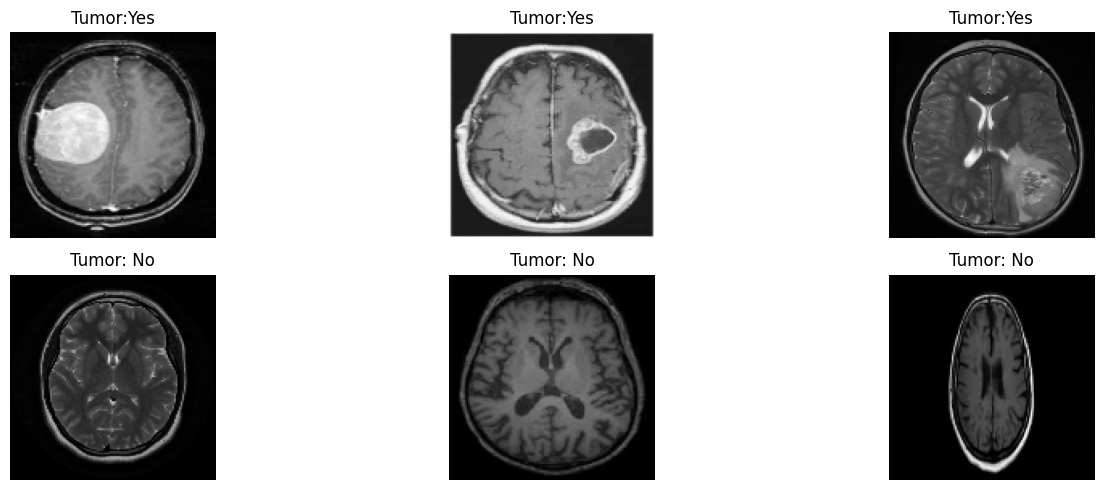

In [4]:
plt.figure(figsize=(15,5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor:Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

# Labels Distribution

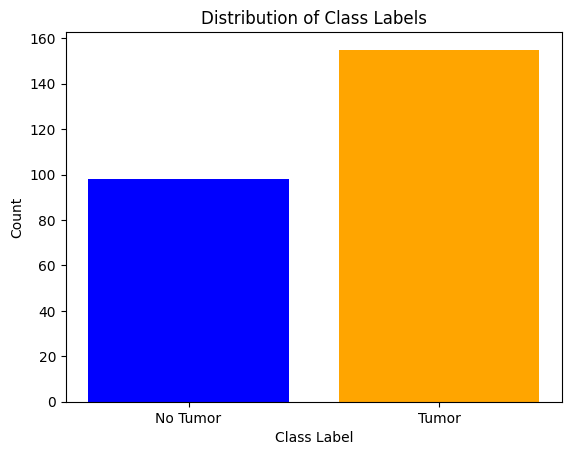

In [5]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

# Brain Cropping Function

We need to create a cropping function to focus on our region of interest and remove unwanted parts of the image

In [6]:
def crop_brain_region(image, size):
    
    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)
    
    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)
    
    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]
    
    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)
    
    return contour_image, bounding_box_image, cropped_image, resized_image

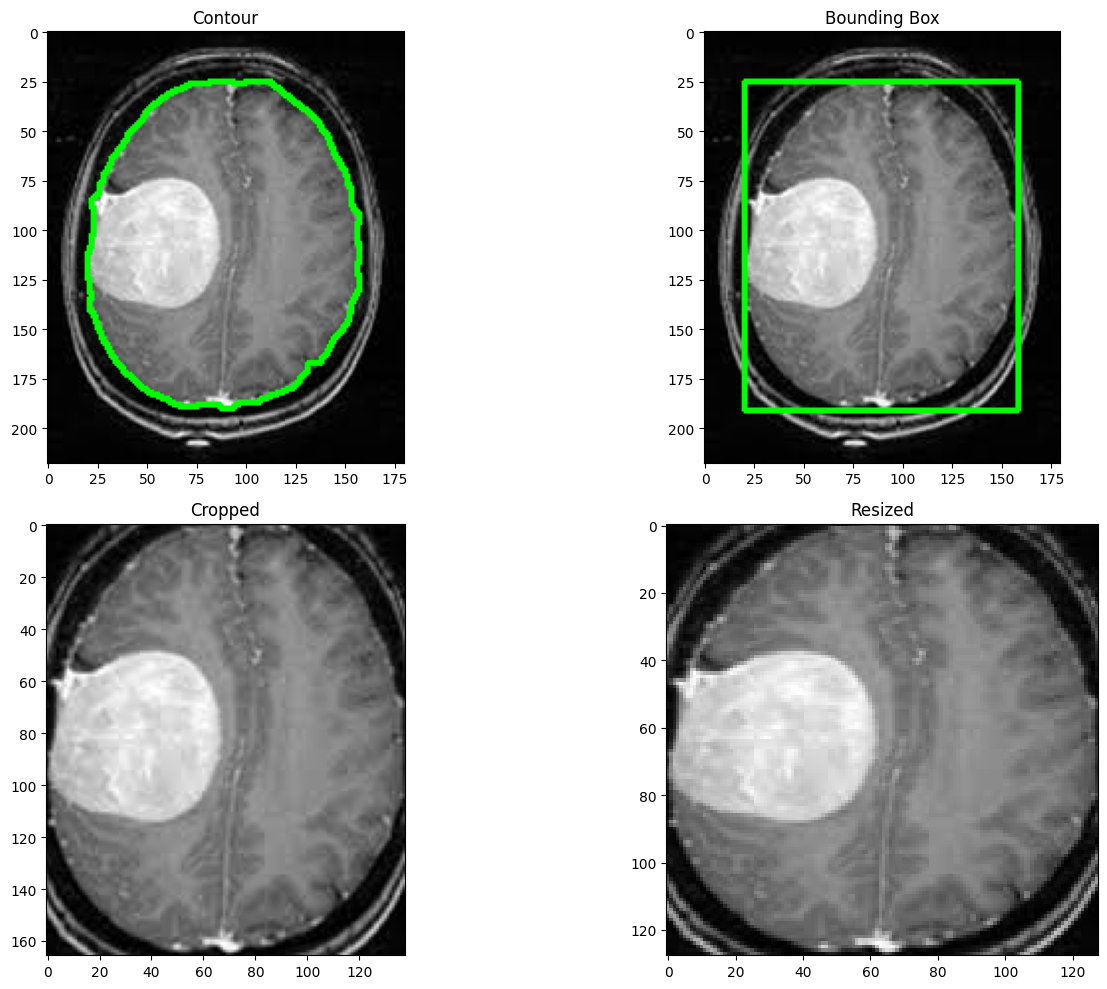

In [7]:
output_size = (128, 128)
example_image = cv2.imread(r"C:\Users\akshi\Downloads\Brain Tumor Classification cnn & vgg16\yes\Y1.jpg")
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)


contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2 , 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)



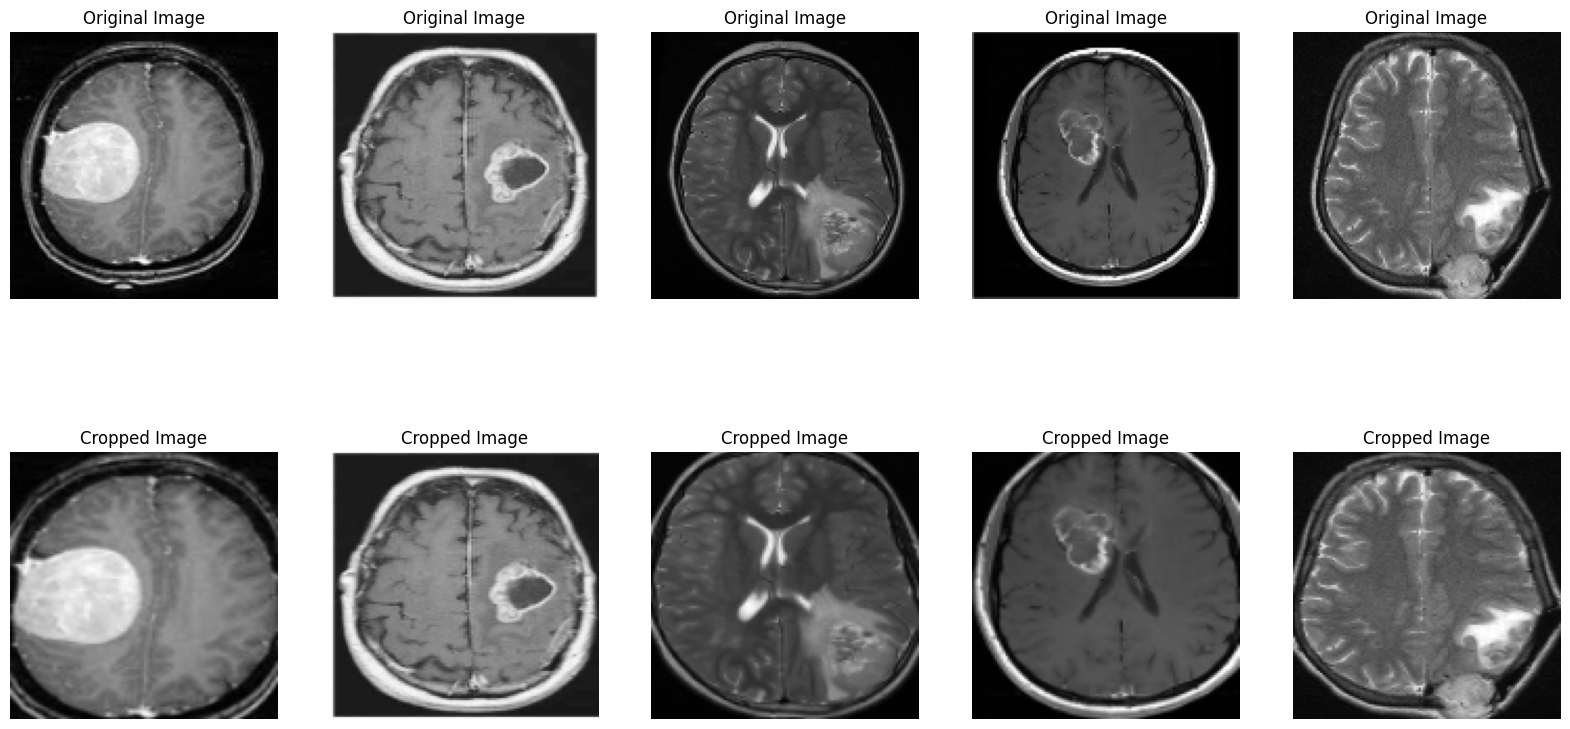

In [8]:
num_images_per_class = 5
class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20,10))

for i in range(num_images_per_class):
    plt.subplot(2,num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()
    

# Data Splitting

Now, we split the data into training, validation, and test sets. But first we have to transform our all_cropped list into a numpy array.

In [9]:
all_cropped=np.array(all_cropped)

In [10]:
# Shuffling the data to make sure the images are randomized and there is no order in labels

all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)


print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 128, 128, 3)
Train labels shape: (202,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [11]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [12]:
train_images= train_images/255
test_images=test_images/255
val_images=val_images/255

In [13]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


# Baseline CNN

I'm using a simple architecture for comparison purposes. Feel free to play around with this model by adding more layers!

In [14]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

Early stopping: Regularization technique used to stop overfitting by monitoring the model's performance and stopping the training when the model is doing better at training than at validating.

In [15]:
epochs = 50
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')   # Defining early stopping to stop the model from overfitting
history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 3s 291ms/step - loss: 0.6812 - accuracy: 0.5693 - val_loss: 0.6357 - val_accuracy: 0.6923
Epoch 2/50
7/7 [==============================] - 2s 257ms/step - loss: 0.6567 - accuracy: 0.6089 - val_loss: 0.6181 - val_accuracy: 0.6923
Epoch 3/50
7/7 [==============================] - 2s 258ms/step - loss: 0.6619 - accuracy: 0.6089 - val_loss: 0.6155 - val_accuracy: 0.6923
Epoch 4/50
7/7 [==============================] - 2s 260ms/step - loss: 0.6446 - accuracy: 0.6089 - val_loss: 0.6223 - val_accuracy: 0.6923
Epoch 5/50
7/7 [==============================] - 2s 262ms/step - loss: 0.6598 - accuracy: 0.6089 - val_loss: 0.6256 - val_accuracy: 0.6923
Epoch 6/50
7/7 [==============================] - 2s 264ms/step - loss: 0.6432 - accuracy: 0.6089 - val_loss: 0.6117 - val_accuracy: 0.6923
Epoch 7/50
7/7 [==============================] - 2s 267ms/step - loss: 0.6310 - accuracy: 0.6089 - val_loss: 0.5982 - val_accuracy: 0.6923
Epoch 8/50
7/7 [====


Let's see the confusion matrix of this model on the validation & test sets.

1/1 [==============================] - 0s 203ms/step
Accuarcy on Validation Set: 0.808 %


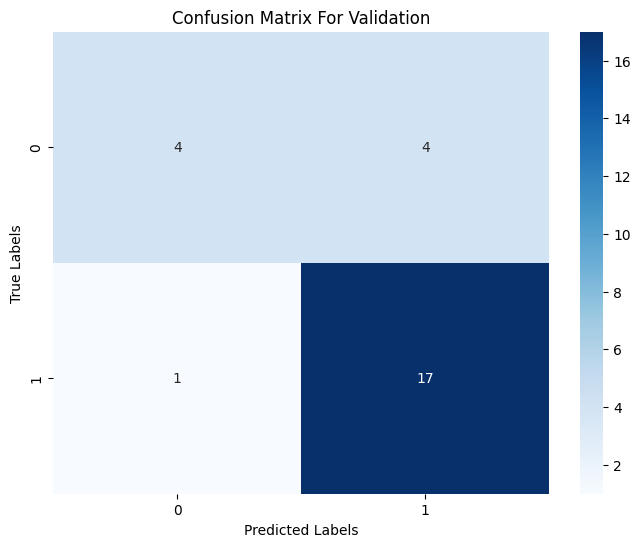

In [16]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
conf_matrix = confusion_matrix(val_labels, binary_predictions)
accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuarcy on Validation Set: {:.3f} %" .format(accuracy))
      
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 116ms/step
Accuracy on Test Set: 0.800 %


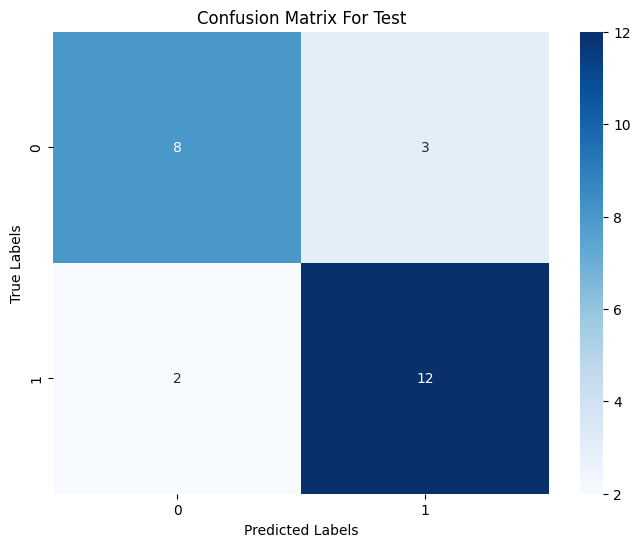

In [17]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

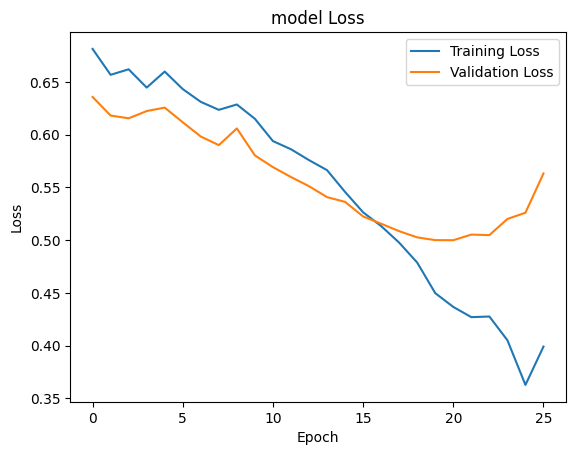

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Acheiving 76.9% on the validation set & 84% on the test set. Now let's try adding data augmentation and pretrained models to see how the results could be improved.

# Data Augmentation

Using ImageDataGenerator to perform data augmentation on the training set. This helps increase the diversity of the training data and improve the model's generalization ability.

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=20,              # Random rotation by 0 to 20 degrees
    horizontal_flip=True,           # Random horizontal flipping
    vertical_flip=True,             # Random vertical flipping
    width_shift_range=0.1,          # Random width shifting by 10% of total width
    height_shift_range=0.1,         # Random height shifting by 10% of total height
    shear_range=0.1,                # Shear intensity by 0.1 radians
    zoom_range=0.1,                 # Random zooming by 10%
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(train_images, train_labels,batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels,batch_size=32)

Visualizing the new augmented images

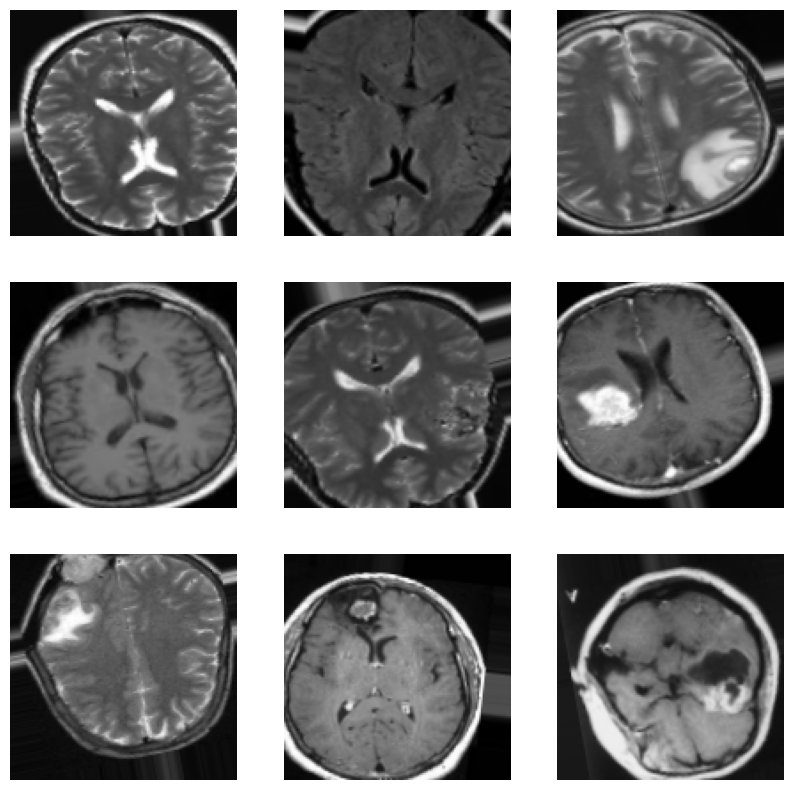

In [20]:
augmented_images, _ = train_datagen.flow(train_images, train_labels, batch_size=32).next()
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


# VGG16

Using a pre-trained VGG16 model with keras-pretrained-models weights, because it provides a well-established convolutional neural network architecture that has been trained on a large dataset (ImageNet). By using a pre-trained model like VGG16, we can benefit from the features learned during its training on ImageNet, which includes detecting various shapes, textures, and patterns in images.

In [21]:
base_model = VGG16(weights=r"C:\Users\akshi\OneDrive\Documents\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(128, 128, 3))

base_model.layers[0].trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)  
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 [==============================] - 36s 5s/step - loss: 1.1699 - accuracy: 0.4208 - val_loss: 1.0279 - val_accuracy: 0.3077 - lr: 1.0000e-05
Epoch 2/200
7/7 [==============================] - 35s 5s/step - loss: 1.0052 - accuracy: 0.5000 - val_loss: 0.8713 - val_accuracy: 0.7692 - lr: 1.0000e-05
Epoch 3/200
7/7 [==============================] - 36s 6s/step - loss: 0.9545 - accuracy: 0.5347 - val_loss: 0.7842 - val_accuracy: 0.6923 - lr: 1.0000e-05
Epoch 4/200
7/7 [==============================] - 36s 5s/step - loss: 0.9123 - accuracy: 0.5941 - val_loss: 0.7541 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 5/200
7/7 [==============================] - 36s 5s/step - loss: 0.8460 - accuracy: 0.6436 - val_loss: 0.7025 - val_accuracy: 0.7692 - lr: 1.0000e-05
Epoch 6/200
7/7 [==============================] - 37s 5s/step - loss: 0.8120 - accuracy: 0.6832 - val_loss: 0.6776 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 7/200
7/7 [==============================] - 38s 5s/step -

1/1 [==============================] - 1s 657ms/step
Accuracy on Validation Set: 0.961538


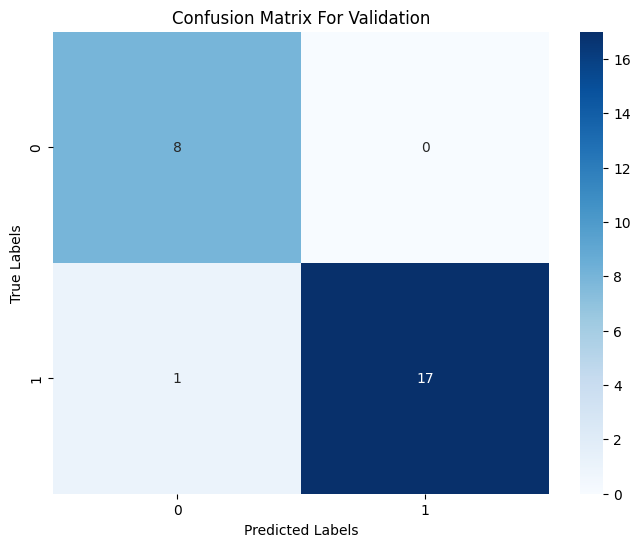

In [23]:
predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 1s 550ms/step
Accuracy on Test Set: 0.960000


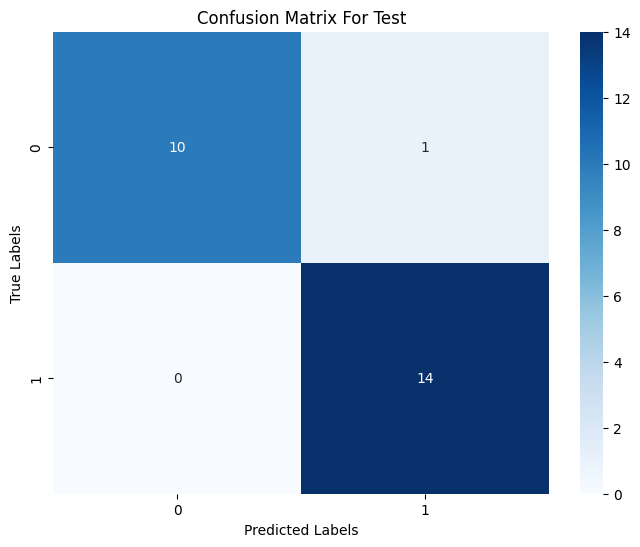

In [24]:
predictions = model.predict(test_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

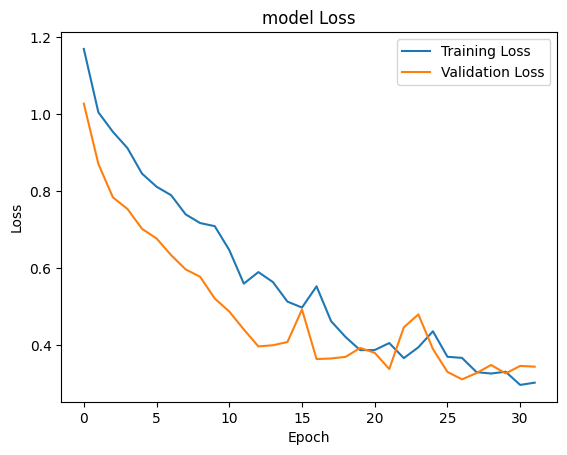

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

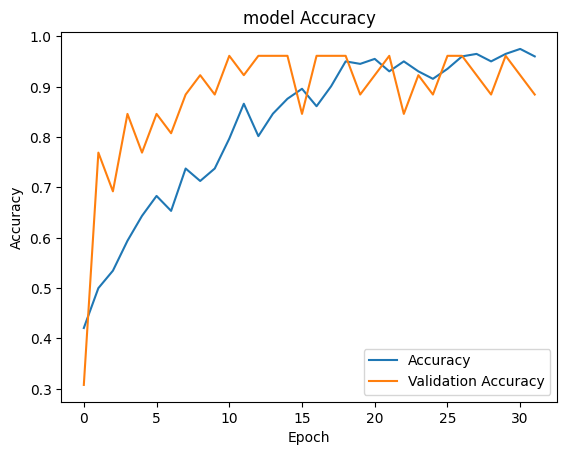

In [26]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Conclusion

As we can see, employing data augmentation and a pretrained model resulted in significantly higher accuracy. The accuracy of the test set runs from 80% to 96%, while the validation accuracy goes from % to 96%, which is excellent! The models' instability is caused by the dataset's short size and the presence of many similar, if not duplicate, photos.